In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import SensitivityAtSpecificity
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, matthews_corrcoef
from sklearn.preprocessing import Binarizer
from imblearn.over_sampling import ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN


from sklearn.model_selection import StratifiedKFold


import numpy as np
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    confusion_matrix,
    roc_curve
)



def calculate_evaluation_metrics(y_true, y_pred_probs, target_specificity):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    specificity = 1 - fpr
    # 找到最接近目标特异性的阈值索引
    closest_index = np.argmin(np.abs(specificity - target_specificity))
    best_threshold = thresholds[closest_index]
    y_pred = y_pred_probs >= best_threshold
    
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    sn = recall_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    return acc, auc, precision, sn, mcc, best_threshold

def calculate(y_true, y_pred_probs):
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    specificity = 1 - fpr


    best_threshold = 0.5
    y_pred = y_pred_probs >= best_threshold
    
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    sn = recall_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    return acc, auc, precision, sn, mcc

In [2]:
RACE_Samples = pd.read_csv("TCGA_RACE.csv")

In [100]:
WHITE = RACE_Samples[RACE_Samples["RACE"] == "WHITE"]["A0_Samples"].values
BLACK = RACE_Samples[RACE_Samples["RACE"] == "BLACK"]["A0_Samples"].values
all_sim = set(pd.read_csv(r"最终数据/tcga_clinical.csv", index_col=0).T.columns)
WHITE = list(all_sim & set(WHITE))
BLACK = list(all_sim & set(BLACK))

In [105]:
def remove_duplicate_columns(df):
    """
    移除DataFrame中的重复列名，只保留第一次出现的列。

    参数:
    df: pd.DataFrame, 原始DataFrame。

    返回:
    df_unique_columns: pd.DataFrame, 移除重复列名后的DataFrame。
    """
    # 查找重复的列名
    duplicated_columns = df.columns.duplicated()

    # 选择不重复的列
    df_unique_columns = df.loc[:, ~duplicated_columns]
    
    return df_unique_columns

In [161]:
TCGA_cna = pd.read_csv("gene.csv",index_col=0)
TCGA_gene = pd.read_csv("cna.csv",index_col=0)


In [162]:
TCGA_cna = remove_duplicate_columns(TCGA_cna.T).T
TCGA_gene = remove_duplicate_columns(TCGA_gene.T).T

In [165]:
TCGA_gene_WHITE = TCGA_gene.T[WHITE].T
TCGA_gene_BLACK = TCGA_gene.T[BLACK].T

TCGA_cna_WHITE = TCGA_cna.T[WHITE].T
TCGA_cna_BLACK = TCGA_cna.T[BLACK].T

In [178]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
import pandas as pd


def feature_selection_linear_svc(X, y ,fea_num=100):
    # Initialize LinearSVC with L1 penalty, which is suitable for feature selection
    lsvc = LinearSVC(max_iter=1000000, penalty="l1", dual=False)

    # Initialize SelectFromModel using LinearSVC
    selector = SelectFromModel(lsvc, max_features=fea_num)
    selector.fit(X, y)
    
    # Get the mask of the selected features
    support_mask = selector.get_support()
    
    # Return the DataFrame with the selected features and the mask
    return X.loc[:, support_mask]



In [222]:
TCGA_label_BLACK = TCGA_label_BLACK.astype(int)
TCGA_gene_BLACK_65 = feature_selection_linear_svc(TCGA_gene_BLACK, TCGA_label_BLACK, fea_num=65)

TCGA_cna_BLACK_100 = feature_selection_linear_svc(TCGA_cna_BLACK, TCGA_label_BLACK, fea_num=100)

In [188]:
TCGA_label_WHITE  = TCGA_label_WHITE.astype(int)
TCGA_gene_WHITE_280 = feature_selection_linear_svc(TCGA_gene_WHITE, TCGA_label_WHITE, fea_num=280)

TCGA_cna_WHITE_280 = feature_selection_linear_svc(TCGA_cna_WHITE, TCGA_label_WHITE, fea_num=280)

In [281]:
TCGA_clinical_WHITE = pd.read_csv(r"最终数据/tcga_clinical.csv", index_col=0).T[WHITE]
TCGA_clinical_BLACK = pd.read_csv(r"最终数据/tcga_clinical.csv", index_col=0).T[BLACK]


In [224]:
TCGA_gene_BLACK_65.to_csv("TCGA_gene_BLACK_65.csv")
TCGA_cna_BLACK_100.to_csv("TCGA_cna_BLACK_100.csv")

TCGA_gene_WHITE_280.to_csv("TCGA_gene_WHITE_280.csv")
TCGA_cna_WHITE_280.to_csv("TCGA_cna_WHITE_280.csv")

In [306]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

probabilities_gene = []
probabilities_cna = []
probabilities_clin = []
true_labels = []

for train_index, test_index in skf.split(TCGA_gene_WHITE_280.values, TCGA_label_WHITE):
    
    X_train, X_test = TCGA_gene_WHITE_280.values[train_index], TCGA_gene_WHITE_280.values[test_index]
    y_train, y_test = TCGA_label_WHITE[train_index], TCGA_label_WHITE[test_index]
    lsvc = LogisticRegression(max_iter=1000000)
    lsvc.fit(X_train, y_train)
    proba = lsvc.predict_proba(X_test)[:, 1]  # 获取正类的概率
    probabilities_gene.extend(proba)
    
    # 保存真实标签
    
    X_train, X_test = TCGA_cna_WHITE_280.values[train_index], TCGA_cna_WHITE_280.values[test_index]
    lsvc = LogisticRegression(max_iter=1000000)
    lsvc.fit(X_train, y_train)
    proba = lsvc.predict_proba(X_test)[:, 1]  # 获取正类的概率
    probabilities_cna.extend(proba)


    
    X_train, X_test = TCGA_clinical_WHITE.T.values[train_index], TCGA_clinical_WHITE.T.values[test_index]
    lsvc = LogisticRegression(max_iter=1000000)
    lsvc.fit(X_train, y_train)
    proba = lsvc.predict_proba(X_test)[:, 1]  # 获取正类的概率
    probabilities_clin.extend(proba)
    
    true_labels.extend(y_test)


In [313]:
pd.DataFrame([probabilities_clin,probabilities_cna, probabilities_gene,true_labels],index=["clincal","cna","gene","trues"]).T.to_csv("白人结果.csv")

In [346]:
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv("黑人结果.csv", index_col=0)
X = data[["clincal", "cna", "gene"]].values
y = data["trues"].values.astype(int)

rf_preds = []

true_labels = []

skf = StratifiedKFold(n_splits=5, shuffle=False)
for train_index, test_index in skf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Random Forest
    rf_model = RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_preds.extend(list(rf_model.predict_proba(X_test)[:, 1]))
    true_labels.extend(list(y_test))

In [347]:
data[["clincal", "cna", "gene"]].values
print(calculate(y, data["clincal"].values))
print(calculate(y, data["cna"].values))
print(calculate(y, data["gene"].values))

print(calculate(true_labels, rf_preds))

(0.8674033149171271, 0.8103802672147995, 0.8214285714285714, 0.5476190476190477, 0.5972806513587573)
(0.9171270718232044, 0.9837273038711888, 0.9090909090909091, 0.7142857142857143, 0.7573406602864717)
(0.994475138121547, 0.999828708461802, 0.9767441860465116, 1.0, 0.9847422248772766)
(0.994475138121547, 0.9998287084618019, 1.0, 0.9761904761904762, 0.9844885408550117)


In [315]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

probabilities_gene = []
probabilities_cna = []
probabilities_clin = []
true_labels = []

for train_index, test_index in skf.split(TCGA_gene_BLACK_280.values, TCGA_label_BLACK):
    
    X_train, X_test = TCGA_gene_BLACK_65.values[train_index], TCGA_gene_BLACK_65.values[test_index]
    y_train, y_test = TCGA_label_BLACK[train_index], TCGA_label_BLACK[test_index]
    lsvc = LogisticRegression(max_iter=1000000)
    lsvc.fit(X_train, y_train)
    proba = lsvc.predict_proba(X_test)[:, 1]  # 获取正类的概率
    probabilities_gene.extend(proba)
    
    # 保存真实标签
    
    X_train, X_test = TCGA_cna_BLACK_100.values[train_index], TCGA_cna_BLACK_100.values[test_index]
    lsvc = LogisticRegression(max_iter=1000000)
    lsvc.fit(X_train, y_train)
    proba = lsvc.predict_proba(X_test)[:, 1]  # 获取正类的概率
    probabilities_cna.extend(proba)


    
    X_train, X_test = TCGA_clinical_BLACK.T.values[train_index], TCGA_clinical_BLACK.T.values[test_index]
    lsvc = LogisticRegression(max_iter=1000000)
    lsvc.fit(X_train, y_train)
    proba = lsvc.predict_proba(X_test)[:, 1]  # 获取正类的概率
    probabilities_clin.extend(proba)
    
    true_labels.extend(y_test)
|728788

In [352]:
del TCGA_gene["?|728788"]

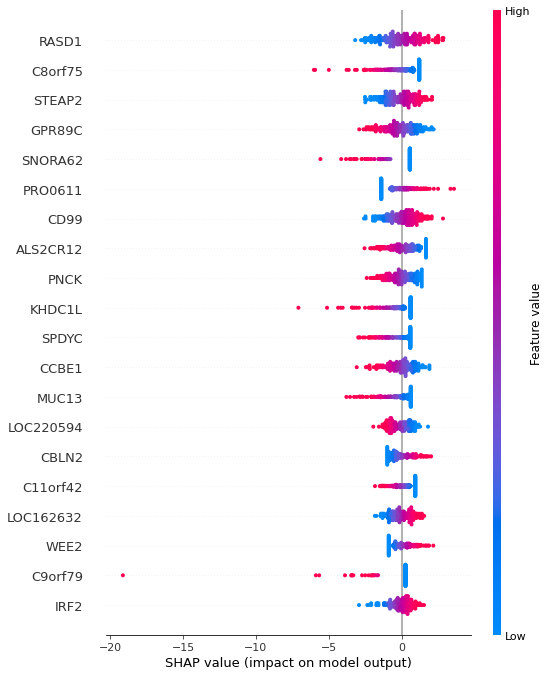

In [353]:
# 导入所需的库
import shap
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# 假设你已经有了数据集 X 和目标变量 y
X = TCGA_gene  # 特征矩阵
y = TCGA_label # 目标变量

# 分割数据集以进行训练和测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 初始化SHAP解释器
explainer = shap.Explainer(model, X_train)

# 计算SHAP值
shap_values = explainer(X_test)

# 生成可视化图表

## 水流图（Waterfall plot）- 展示单个预测的贡献
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig('ALL_waterfall_plot.png', dpi=300, format='png')
plt.clf()  # 清除当前图像

## 摘要图（Summary plot）- 展示所有特征对模型的整体贡献
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('ALL_Summary_plot.png', dpi=300, format='png')
# ## 依赖关系图（Dependence plot）- 展示特征与模型输出之间的关系
# for feature_name in X.columns:
#     shap.dependence_plot(feature_name, shap_values.values, X_test)

    

In [317]:
pd.DataFrame([probabilities_clin,probabilities_cna, probabilities_gene,true_labels],index=["clincal","cna","gene","trues"]).T.to_csv("黑人结果.csv")

In [316]:
print(calculate(true_labels, probabilities_clin))
print(calculate(true_labels, probabilities_cna))
print(calculate(true_labels, probabilities_gene))

(0.8674033149171271, 0.8103802672147995, 0.8214285714285714, 0.5476190476190477, 0.5972806513587573)
(0.9171270718232044, 0.9837273038711888, 0.9090909090909091, 0.7142857142857143, 0.7573406602864717)
(0.994475138121547, 0.999828708461802, 0.9767441860465116, 1.0, 0.9847422248772766)


In [303]:
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score
from sklearn.linear_model import LogisticRegression

X = TCGA_gene_WHITE_280.values
y = TCGA_label_WHITE

# 初始化 LinearSVC 模型
lsvc = LogisticRegression(max_iter=1000000)

# 使用 StratifiedKFold 进行分层抽样
cv = StratifiedKFold(n_splits=5)

# 定义评分指标
scoring = {
    'acc': 'accuracy',
    'auc': make_scorer(roc_auc_score, needs_threshold=True),
    'pre': 'precision',
    'rec': 'recall',
    'mcc': make_scorer(matthews_corrcoef)
}

# 进行交叉验证
scores = cross_validate(lsvc, X, y, cv=cv, scoring=scoring, return_train_score=False, return_estimator=True)

# 打印每一折的评分指标
print("Accuracy for each fold: ", scores['test_acc'])
print("AUC for each fold: ", scores['test_auc'])
print("Precision for each fold: ", scores['test_pre'])
print("Recall for each fold: ", scores['test_rec'])
print("MCC for each fold: ", scores['test_mcc'])

# 打印每个评分指标的平均值和标准偏差
print("\nAverage accuracy: ", scores['test_acc'].mean(), "Standard Deviation: ", scores['test_acc'].std())
print("Average AUC: ", scores['test_auc'].mean(), "Standard Deviation: ", scores['test_auc'].std())
print("Average precision: ", scores['test_pre'].mean(), "Standard Deviation: ", scores['test_pre'].std())
print("Average recall: ", scores['test_rec'].mean(), "Standard Deviation: ", scores['test_rec'].std())
print("Average MCC: ", scores['test_mcc'].mean(), "Standard Deviation: ", scores['test_mcc'].std())

Accuracy for each fold:  [0.99328859 0.99328859 0.97297297 0.98648649 0.97972973]
AUC for each fold:  [1.         0.99977064 1.         0.99976476 0.99929428]
Precision for each fold:  [1.         1.         1.         1.         0.97368421]
Recall for each fold:  [0.97435897 0.975      0.8974359  0.94871795 0.94871795]
MCC for each fold:  [0.98263979 0.98292236 0.93041295 0.96520668 0.94748942]

Average accuracy:  0.9851532740794486 Standard Deviation:  0.007898338731533481
Average AUC:  0.9997659374264878 Standard Deviation:  0.00025770189546126486
Average precision:  0.9947368421052631 Standard Deviation:  0.010526315789473672
Average recall:  0.9488461538461539 Standard Deviation:  0.02820629368221408
Average MCC:  0.9617342391563053 Standard Deviation:  0.02040575766021115


In [330]:
TCGA_clinical = pd.read_csv(r"最终数据/tcga_clinical.csv", index_col=0).T[WHITE].T.values
TCGA_clinical = MinMaxScaler().fit_transform(TCGA_clinical)
TCGA_label = pd.read_csv(r"最终数据/tcga_label.csv", index_col=0)["os_label"].values
TCGA_gene = pd.read_csv(r"最终数据/final_tcga_gene.csv", index_col=0)
TCGA_cna = pd.read_csv(r"最终数据/final_tcga_cna.csv", index_col=0).T[WHITE].T.values

TCGA_label = TCGA_label.astype(int)

In [122]:
TCGA_label_WHITE = pd.read_csv(r"最终数据/tcga_label.csv", index_col=0).T[WHITE].T["os_label"].values
TCGA_label_BLACK = pd.read_csv(r"最终数据/tcga_label.csv", index_col=0).T[BLACK].T["os_label"].values


In [121]:
TCGA_label_BLACK

A0_Samples
TCGA-A2-A0YF    0
TCGA-OL-A5RV    0
TCGA-LL-A7SZ    0
TCGA-OL-A5RW    0
TCGA-EW-A6SD    0
               ..
TCGA-PL-A8LV    0
TCGA-OL-A66L    0
TCGA-S3-AA14    0
TCGA-3C-AALK    0
TCGA-A2-A4RX    0
Name: os_label, Length: 181, dtype: object

In [87]:
import pickle
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(TCGA_cna, TCGA_label)):
    with open(f'BLACK_train_index_fold{i}.pkl', 'wb') as f:
        pickle.dump(train_index, f)
    with open(f'BLACK_test_index_fold{i}.pkl', 'wb') as f:
        pickle.dump(test_index, f)

# 临床信息

In [88]:
import tensorflow as tf
from tensorflow.keras import Model, initializers
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Layer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.activations import sigmoid
from keras.models import Model
from keras.layers import Conv1D, Flatten, Dense, Input
from keras import initializers, regularizers
from keras import layers, models, initializers, backend as K
from keras.activations import softmax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Concatenate, Dropout, Flatten, Dense
from tensorflow.keras.initializers import GlorotNormal, Constant
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, initializers

class ExternalAttention(layers.Layer):
    def __init__(self, d_model=96, S=64, **kwargs):
        super(ExternalAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.S = S
        self.mk = layers.Dense(S, use_bias=False, kernel_initializer=initializers.RandomNormal(stddev=0.001))
        self.mv = layers.Dense(self.d_model, use_bias=False, kernel_initializer=initializers.RandomNormal(stddev=0.001))

    def call(self, queries):
        attn = self.mk(queries)  # [bs, n, S]
        attn = tf.nn.softmax(attn)  # [bs, n, S]
        attn = attn / tf.reduce_sum(attn, axis=2, keepdims=True)  # Normalize the softmax output [bs, n, S]
        out = self.mv(attn)  # [bs, n, d_model]
        return out

    def get_config(self):
        config = super(ExternalAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'S': self.S
        })
        return config 
    
    
class ChannelGatingLayer(Layer):
    def __init__(self, channels, **kwargs):
        super(ChannelGatingLayer, self).__init__(**kwargs)
        self.channels = channels
        self.gamma = self.add_weight(shape=(1, 1, channels), initializer=Constant(value=1.0), trainable=True)
        self.beta = self.add_weight(shape=(1, 1, channels), initializer=Constant(value=0.0), trainable=True)

    def call(self, inputs, **kwargs):
        # Channel gating computation
        avg = GlobalAveragePooling1D()(inputs)
        avg = tf.expand_dims(avg, axis=1)  # Make it 3D to match with gamma and beta
        avg = tf.add(tf.multiply(avg, self.gamma), self.beta)
        avg = tf.sigmoid(avg)
        
        # Apply gating to the inputs
        return inputs * avg

def create_clincal_model(input_shape):
    init = GlorotNormal(seed=1)
    bias_init = Constant(value=0.1)
    
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=10, kernel_size=2, strides=1, padding="same",
               kernel_initializer=init, bias_initializer=bias_init)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    residual = x

    xp1 = Conv1D(filters=10, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    xp1 = BatchNormalization()(xp1)

    xp2 = Conv1D(filters=10, kernel_size=3, strides=1, dilation_rate=2, padding="same", use_bias=False)(x)
    xp2 = BatchNormalization()(xp2)

    x = Concatenate(axis=-1)([xp1, xp2])
    x = Dropout(0.5)(x) 
 
    # Assuming ExternalAttention is a custom layer that you've defined elsewhere
    x = ExternalAttention(d_model=20)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)  

    x = x + Conv1D(filters=20, kernel_size=1, strides=1, use_bias=False)(residual)
    x = BatchNormalization()(x)
   
    x = Flatten()(x)

    x = Dense(units=300, activation="tanh", kernel_regularizer=l1(0.01))(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model


In [89]:
from sklearn.utils.class_weight import compute_sample_weight

fold_no = 1
scores = []
all_y_true = []
all_y_prob = []
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
all_fold_histories = []


for i in range(5):  
    with open(f'BLACK_train_index_fold{i}.pkl', 'rb') as f:
        train_index = pickle.load(f)
    with open(f'BLACK_test_index_fold{i}.pkl', 'rb') as f:
        test_index = pickle.load(f)
    
    X_train, X_test = TCGA_clinical[train_index], TCGA_clinical[test_index]
    y_train, y_test = TCGA_label[train_index], TCGA_label[test_index]
    
    smote_enn = ADASYN(random_state=42)

    X_train, y_train = smote_enn.fit_resample(X_train, y_train)
    
    model = create_clincal_model(input_shape = (11, 1))
    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, batch_size=8, verbose=1)
    all_fold_histories.append(history.history)
    # 评估模型
    scores = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test).reshape(-1)
    all_y_true.extend(y_test)
    all_y_prob.extend(y_pred_prob)
    metrics = calculate_evaluation_metrics(y_test, y_pred_prob, 0.95)
    print('Score fo/r fold',fold_no,metrics)
    fold_no += 1
print(calculate_evaluation_metrics(all_y_true, all_y_prob, 0.95))
pd.DataFrame([all_y_true,all_y_prob]).T.to_csv("BLACK_clincal.csv")
# wu(0.8811513463324049, 0.8787080689909397, 0.7980295566502463, 0.6506024096385542, 0.6479587505455906, 0.53422964)
# (0.8644382544103992, 0.887356188037173, 0.7783783783783784, 0.5783132530120482, 0.5910646621570037, 0.89936125)


(0.8679245283018868, 0.8932682963295209, 0.810126582278481, 0.6530612244897959, 0.644132086346931, 0.7824894)

Training on fold 1...
Epoch 1/50
28/28 [==============================] - 0s 14ms/step - loss: 30.5075 - accuracy: 0.7110 - val_loss: 24.7177 - val_accuracy: 0.7297
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 19.9153 - accuracy: 0.8028 - val_loss: 15.5194 - val_accuracy: 0.2432
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 11.8216 - accuracy: 0.8119 - val_loss: 8.9713 - val_accuracy: 0.2432
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 6.4645 - accuracy: 0.8486 - val_loss: 5.1203 - val_accuracy: 0.2432
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 3.6364 - accuracy: 0.8349 - val_loss: 3.2861 - val_accuracy: 0.2432
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 2.2058 - accuracy: 0.8211 - val_loss: 2.3113 - val_accuracy: 0.2432
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 1.6157 - accuracy: 0.7752 - val_loss: 1.9638 - val_accuracy:

Epoch 8/50
28/28 [==============================] - 0s 4ms/step - loss: 1.3374 - accuracy: 0.7812 - val_loss: 1.6174 - val_accuracy: 0.2222
Epoch 9/50
28/28 [==============================] - 0s 4ms/step - loss: 1.1134 - accuracy: 0.7991 - val_loss: 1.5371 - val_accuracy: 0.2222
Epoch 10/50
28/28 [==============================] - 0s 4ms/step - loss: 1.0132 - accuracy: 0.7500 - val_loss: 1.4343 - val_accuracy: 0.2222
Epoch 11/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9838 - accuracy: 0.7589 - val_loss: 1.4189 - val_accuracy: 0.2222
Epoch 12/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9446 - accuracy: 0.7545 - val_loss: 1.1913 - val_accuracy: 0.3056
Epoch 13/50
28/28 [==============================] - 0s 3ms/step - loss: 0.8832 - accuracy: 0.7902 - val_loss: 1.1551 - val_accuracy: 0.4167
Epoch 14/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9040 - accuracy: 0.7634 - val_loss: 1.3226 - val_accuracy: 0.2500
Epoch 15/50
28/

Epoch 17/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9268 - accuracy: 0.7937 - val_loss: 1.1948 - val_accuracy: 0.5278
Epoch 18/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9609 - accuracy: 0.7937 - val_loss: 1.4047 - val_accuracy: 0.3056
Epoch 19/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9065 - accuracy: 0.7982 - val_loss: 1.3532 - val_accuracy: 0.3333
Epoch 20/50
28/28 [==============================] - 0s 4ms/step - loss: 0.8912 - accuracy: 0.7758 - val_loss: 1.0958 - val_accuracy: 0.4722
Epoch 21/50
28/28 [==============================] - 0s 4ms/step - loss: 0.8920 - accuracy: 0.8072 - val_loss: 0.9840 - val_accuracy: 0.8056
Epoch 22/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9656 - accuracy: 0.7758 - val_loss: 1.1620 - val_accuracy: 0.6389
Epoch 23/50
28/28 [==============================] - 0s 4ms/step - loss: 0.9781 - accuracy: 0.7803 - val_loss: 1.1033 - val_accuracy: 0.6944
Epoch 24/50
2

E:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5...
Epoch 1/50
29/29 [==============================] - 0s 13ms/step - loss: 30.2899 - accuracy: 0.7368 - val_loss: 24.3364 - val_accuracy: 0.6667
Epoch 2/50
29/29 [==============================] - 0s 4ms/step - loss: 19.4931 - accuracy: 0.7763 - val_loss: 15.0764 - val_accuracy: 0.2500
Epoch 3/50
29/29 [==============================] - 0s 4ms/step - loss: 11.4251 - accuracy: 0.7851 - val_loss: 8.6939 - val_accuracy: 0.2500
Epoch 4/50
29/29 [==============================] - 0s 4ms/step - loss: 6.2361 - accuracy: 0.8026 - val_loss: 5.0494 - val_accuracy: 0.2500
Epoch 5/50
29/29 [==============================] - 0s 4ms/step - loss: 3.5100 - accuracy: 0.7895 - val_loss: 3.1682 - val_accuracy: 0.2500
Epoch 6/50
29/29 [==============================] - 0s 4ms/step - loss: 2.1973 - accuracy: 0.8026 - val_loss: 2.1972 - val_accuracy: 0.2500
Epoch 7/50
29/29 [==============================] - 0s 4ms/step - loss: 1.5166 - accuracy: 0.7895 - val_loss: 1.7316 - val_accuracy:

E:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.8679245283018868,
 0.8932682963295209,
 0.810126582278481,
 0.6530612244897959,
 0.644132086346931,
 0.7824894)

# 拷贝数变异

In [90]:
def create_cna_model(input_shape):
    init = GlorotNormal(seed=1)
    bias_init = Constant(value=0.1)
    
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=10, kernel_size=2, strides=1, padding="same",
               kernel_initializer=init, bias_initializer=bias_init)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    residual = x

    xp1 = Conv1D(filters=10, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    xp1 = BatchNormalization()(xp1)

    xp2 = Conv1D(filters=10, kernel_size=3, strides=1, dilation_rate=2, padding="same", use_bias=False)(x)
    xp2 = BatchNormalization()(xp2)

    x = Concatenate(axis=-1)([xp1, xp2])
    x = Dropout(0.5)(x) 
 
    # Assuming ExternalAttention is a custom layer that you've defined elsewhere
    x = ExternalAttention(d_model=20)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)  

    x = x + Conv1D(filters=20, kernel_size=1, strides=1, use_bias=False)(residual)
    x = BatchNormalization()(x)
   
    x = Flatten()(x)

    x = Dense(units=300, activation="tanh", kernel_regularizer=l1(0.01))(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model


In [94]:
from sklearn.utils.class_weight import compute_sample_weight

fold_no = 1
scores = []
all_y_true = []
all_y_prob = []
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
all_fold_histories = []

for i in range(5):  
    with open(f'BLACK_train_index_fold{i}.pkl', 'rb') as f:
        train_index = pickle.load(f)
    with open(f'BLACK_test_index_fold{i}.pkl', 'rb') as f:
        test_index = pickle.load(f)
        
    X_train, X_test = TCGA_cna[train_index], TCGA_cna[test_index]
    y_train, y_test = TCGA_label[train_index], TCGA_label[test_index]
    adasyn = ADASYN(random_state=42)
    X_train, y_train = adasyn.fit_resample(X_train, y_train)
    
    model = create_cna_model(input_shape = (280, 1))
    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, batch_size=16, verbose=1)
    
    # 评估模型
    all_fold_histories.append(history.history)
    scores = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test).reshape(-1)
    all_y_true.extend(y_test)
    all_y_prob.extend(y_pred_prob)
    metrics = calculate_evaluation_metrics(y_test, y_pred_prob, 0.95)
    print('Score fo/r fold',fold_no,metrics)
    fold_no += 1
print(calculate(all_y_true, all_y_prob))
pd.DataFrame([all_y_true,all_y_prob]).T.to_csv("BLACK_cna.csv")  #H


Training on fold 1...
Epoch 1/50
14/14 [==============================] - 1s 55ms/step - loss: 192.6658 - accuracy: 0.8009 - val_loss: 115.4292 - val_accuracy: 0.7297
Epoch 2/50
14/14 [==============================] - 1s 38ms/step - loss: 71.4169 - accuracy: 0.9548 - val_loss: 33.9859 - val_accuracy: 0.7297
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 22.6089 - accuracy: 0.9502 - val_loss: 14.9085 - val_accuracy: 0.7568
Epoch 4/50
14/14 [==============================] - 1s 36ms/step - loss: 11.6858 - accuracy: 0.8145 - val_loss: 9.8939 - val_accuracy: 0.7568
Epoch 5/50
14/14 [==============================] - 1s 36ms/step - loss: 8.2925 - accuracy: 0.8688 - val_loss: 7.4183 - val_accuracy: 0.6486
Epoch 6/50
14/14 [==============================] - 1s 37ms/step - loss: 6.5688 - accuracy: 0.8416 - val_loss: 6.9460 - val_accuracy: 0.7568
Epoch 7/50
14/14 [==============================] - 1s 37ms/step - loss: 6.1752 - accuracy: 0.8824 - val_loss: 6.0171 - val

KeyboardInterrupt: 

# 基因表达

In [95]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Concatenate, Dropout, Flatten, Dense
from tensorflow.keras.initializers import GlorotNormal, Constant
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_gene_model(input_shape):
    init = GlorotNormal(seed=1)
    bias_init = Constant(value=0.1)
    
    inputs = Input(shape=input_shape)

    x = Conv1D(filters=25, kernel_size=2, strides=1, padding="same",
               kernel_initializer=init, bias_initializer=bias_init)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    residual = x

    xp1 = Conv1D(filters=10, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    xp1 = BatchNormalization()(xp1)

    xp2 = Conv1D(filters=10, kernel_size=3, strides=1, dilation_rate=2, padding="same", use_bias=False)(x)
    xp2 = BatchNormalization()(xp2)

    x = Concatenate(axis=-1)([xp1, xp2])
    x = Dropout(0.5)(x) 
 
    # Assuming ExternalAttention is a custom layer that you've defined elsewhere
#     x = ExternalAttention(d_model=20)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)  

    x = x + Conv1D(filters=20, kernel_size=1, strides=1, use_bias=False)(residual)
    x = BatchNormalization()(x)
   
    x = Flatten()(x)

    x = Dense(units=300, activation="tanh", kernel_regularizer=l1(0.01))(x)
    x = Dropout(0.5)(x)  
    outputs = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=0.0003)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model

In [96]:
from sklearn.utils.class_weight import compute_sample_weight

fold_no = 1
scores = []
all_y_true = []
all_y_prob = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
all_fold_histories = []
for i in range(5):  
    with open(f'BLACK_train_index_fold{i}.pkl', 'rb') as f:
        train_index = pickle.load(f)
    with open(f'BLACK_test_index_fold{i}.pkl', 'rb') as f:
        test_index = pickle.load(f)
    
    X_train, X_test = TCGA_gene[train_index], TCGA_gene[test_index]
    y_train, y_test = TCGA_label[train_index], TCGA_label[test_index]
    
    smote_enn = ADASYN(random_state=42)

    X_train, y_train = smote_enn.fit_resample(X_train, y_train)
    
    model = create_gene_model(input_shape = (280, 1))
    print(f'Training on fold {fold_no}...')
    history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, batch_size=32, verbose=1)
    
    # 评估模型
    all_fold_histories.append(history.history)
    scores = model.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = model.predict(X_test).reshape(-1)
    all_y_true.extend(y_test)
    all_y_prob.extend(y_pred_prob)
    metrics = calculate_evaluation_metrics(y_test, y_pred_prob, 0.95)
    print('Score fo/r fold',fold_no,metrics)
    fold_no += 1
print(calculate_evaluation_metrics(all_y_true, all_y_prob, 0.95))
pd.DataFrame([all_y_true,all_y_prob]).T.to_csv("BLACK_gene.csv")

Training on fold 1...
Epoch 1/50
7/7 [==============================] - 1s 81ms/step - loss: 255.7282 - accuracy: 0.5882 - val_loss: 238.4705 - val_accuracy: 0.7297
Epoch 2/50
7/7 [==============================] - 0s 51ms/step - loss: 226.2278 - accuracy: 0.8009 - val_loss: 210.1327 - val_accuracy: 0.7297
Epoch 3/50
7/7 [==============================] - 0s 51ms/step - loss: 198.5029 - accuracy: 0.8552 - val_loss: 183.4070 - val_accuracy: 0.7568
Epoch 4/50
7/7 [==============================] - 0s 53ms/step - loss: 172.3825 - accuracy: 0.8914 - val_loss: 158.2881 - val_accuracy: 0.7838
Epoch 5/50
7/7 [==============================] - 0s 58ms/step - loss: 147.9902 - accuracy: 0.9186 - val_loss: 134.9003 - val_accuracy: 0.7838
Epoch 6/50
7/7 [==============================] - 0s 54ms/step - loss: 125.3022 - accuracy: 0.9276 - val_loss: 113.3042 - val_accuracy: 0.8108
Epoch 7/50
7/7 [==============================] - 0s 53ms/step - loss: 104.4676 - accuracy: 0.9412 - val_loss: 93.5795 -

E:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 2...
Epoch 1/50
8/8 [==============================] - 1s 76ms/step - loss: 255.3427 - accuracy: 0.6089 - val_loss: 234.4077 - val_accuracy: 0.8056
Epoch 2/50
8/8 [==============================] - 0s 44ms/step - loss: 223.3267 - accuracy: 0.7689 - val_loss: 205.3647 - val_accuracy: 0.7778
Epoch 3/50
8/8 [==============================] - 0s 46ms/step - loss: 194.5492 - accuracy: 0.8711 - val_loss: 177.4486 - val_accuracy: 0.7500
Epoch 4/50
8/8 [==============================] - 0s 46ms/step - loss: 167.1362 - accuracy: 0.9156 - val_loss: 151.1384 - val_accuracy: 0.7222
Epoch 5/50
8/8 [==============================] - 0s 58ms/step - loss: 141.5153 - accuracy: 0.9067 - val_loss: 126.7818 - val_accuracy: 0.7222
Epoch 6/50
8/8 [==============================] - 0s 47ms/step - loss: 117.8704 - accuracy: 0.9467 - val_loss: 104.4952 - val_accuracy: 0.7778
Epoch 7/50
8/8 [==============================] - 0s 45ms/step - loss: 96.4971 - accuracy: 0.9378 - val_loss: 84.7131 - 

Epoch 3/50
8/8 [==============================] - 0s 46ms/step - loss: 192.5876 - accuracy: 0.8767 - val_loss: 175.0455 - val_accuracy: 0.7778
Epoch 4/50
8/8 [==============================] - 0s 45ms/step - loss: 164.5420 - accuracy: 0.8899 - val_loss: 148.3938 - val_accuracy: 0.8611
Epoch 5/50
8/8 [==============================] - 0s 46ms/step - loss: 138.6503 - accuracy: 0.9251 - val_loss: 123.9042 - val_accuracy: 0.8333
Epoch 6/50
8/8 [==============================] - 0s 45ms/step - loss: 114.8604 - accuracy: 0.9339 - val_loss: 101.4435 - val_accuracy: 0.7500
Epoch 7/50
8/8 [==============================] - 0s 48ms/step - loss: 93.1825 - accuracy: 0.9736 - val_loss: 81.2159 - val_accuracy: 0.7222
Epoch 8/50
8/8 [==============================] - 0s 48ms/step - loss: 73.8211 - accuracy: 0.9736 - val_loss: 63.3355 - val_accuracy: 0.6944
Epoch 9/50
8/8 [==============================] - 0s 48ms/step - loss: 56.8817 - accuracy: 0.9604 - val_loss: 47.9215 - val_accuracy: 0.6111
Epoch

Epoch 5/50
7/7 [==============================] - 0s 64ms/step - loss: 148.1448 - accuracy: 0.9412 - val_loss: 135.0425 - val_accuracy: 0.8333
Epoch 6/50
7/7 [==============================] - 0s 60ms/step - loss: 125.4909 - accuracy: 0.9321 - val_loss: 113.4665 - val_accuracy: 0.8056
Epoch 7/50
7/7 [==============================] - 1s 81ms/step - loss: 104.6521 - accuracy: 0.9412 - val_loss: 93.7618 - val_accuracy: 0.8056
Epoch 8/50
7/7 [==============================] - 0s 58ms/step - loss: 85.7126 - accuracy: 0.9593 - val_loss: 75.9611 - val_accuracy: 0.8056
Epoch 9/50
7/7 [==============================] - 0s 63ms/step - loss: 68.7226 - accuracy: 0.9548 - val_loss: 60.1322 - val_accuracy: 0.7778
Epoch 10/50
7/7 [==============================] - 0s 56ms/step - loss: 53.6846 - accuracy: 0.9729 - val_loss: 46.2448 - val_accuracy: 0.7778
Epoch 11/50
7/7 [==============================] - 0s 64ms/step - loss: 40.6261 - accuracy: 0.9819 - val_loss: 34.3672 - val_accuracy: 0.7222
Epoch 

Epoch 7/50
8/8 [==============================] - 0s 53ms/step - loss: 98.2944 - accuracy: 0.9689 - val_loss: 86.7614 - val_accuracy: 0.6667
Epoch 8/50
8/8 [==============================] - 0s 55ms/step - loss: 80.2183 - accuracy: 0.9156 - val_loss: 70.6545 - val_accuracy: 0.5833
Epoch 9/50
8/8 [==============================] - 0s 61ms/step - loss: 64.4743 - accuracy: 0.9644 - val_loss: 55.8705 - val_accuracy: 0.6389
Epoch 10/50
8/8 [==============================] - 0s 54ms/step - loss: 50.4209 - accuracy: 0.9511 - val_loss: 43.1434 - val_accuracy: 0.6111
Epoch 11/50
8/8 [==============================] - 1s 66ms/step - loss: 38.4768 - accuracy: 0.9778 - val_loss: 32.5976 - val_accuracy: 0.6389
Epoch 12/50
8/8 [==============================] - 1s 71ms/step - loss: 28.8378 - accuracy: 0.9822 - val_loss: 24.3728 - val_accuracy: 0.6111
Epoch 13/50
8/8 [==============================] - 0s 51ms/step - loss: 21.4013 - accuracy: 0.9867 - val_loss: 18.2769 - val_accuracy: 0.6111
Epoch 14/